## Partie I: Preparation des données (preprocessing)

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile

url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

In [4]:
# On choisit un set de features qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui sont disponibles sur les deux années étudiées

# label -> ACTEU

# features à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ;
# DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# Il faut supprimer CSTOT /  CSTOTPRM / CSTOTR puisque ce sont des variables après filtre sur actifs/ inactifs

# Rajouter CSA + CSP ? Catégorie d'emploi mais dispo pour tout le monde

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

# Je pense que le problème principal vient du fait qu'on a en fait trop peu de variable, et donc rien qui ne puisse être vraiment pertinent en fait
#c'est pour cela que les algorithmes ne trouvent rien je pense. (Alexis)

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

#je regarde ce qu'il se passe si je ne sépare pas les trimestres, le prof avait l'air de dire que c'était pas forcément grave (Alexis)
#EEC_2019 = EEC_2019[EEC_2019['TRIM'] ==1]
#EEC_2020 = EEC_2020[EEC_2020['TRIM'] ==4]

# Il y a très peu de valeurs manquantes dans les variables ->  dropna() drops any row that contains at least one missing value
# On aurait aussi pu faire de l'imputation
print(EEC_2019.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)

# Converti l'ensemble des variables catégorielles en dummies
# Oui oui faut le faire, par contre pour les variables qui sont DEJA des dummies, c'est pas la peine, faut juste les recoder en 0 et 1
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
                                             "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R"
                                             , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE variables binaires (dummies)

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)

EEC_2019['ACTIF'] = EEC_2019['ACTEU'].apply(lambda x: (x == 1) or (x == 2))
EEC_2020['ACTIF'] = EEC_2020['ACTEU'].apply(lambda x: (x == 1) or (x == 2))

EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#Vire les anciennes
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

print(EEC_2019.shape)

# Gestion des outliers??? Pas nécessaire ici puisqu'on fonctionne seulement avec des variables catégorielles

# standardisation des variables explicatives ? Pas utile car que des dummies
# (La standardisation permet une convergence plus rapide des algorithmes pour des variables réelles)

EEC_2019_subsample = EEC_2019.sample(n=10000, random_state=3) 


['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']
(412093, 13)
(412093, 13)
(412093, 41)


In [5]:
# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

EMPLOI
False    0.5344
True     0.4656
Name: proportion, dtype: float64


In [6]:
# Description d'une feature pour check booléen
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

count     10000
unique        2
top        True
freq       5291
Name: FEMME, dtype: object


In [8]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
print(X.shape)

# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])
print(y.shape)


print(X[:10])
print(y[:10])


(10000, 37)
(10000,)
[[False  True False False False  True False False  True False False False
  False False False False False False False  True False False False  True
  False False False False False  True False False False  True False False
  False]
 [False False  True False False False False  True False False False  True
  False False False False False False False  True False False False  True
  False False  True False False False False False False  True  True  True
  False]
 [False False  True False False False False  True  True False False False
  False False False False False False False  True False False False  True
  False False False False  True False False False False  True False  True
  False]
 [False False  True False False False  True False  True False False False
  False  True False False False False False False False False False  True
  False False False False  True False False False False False False  True
  False]
 [False False  True False False False False  True  True

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=3)

## Partie II : Support Vector Machine

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param, random_state=3)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))


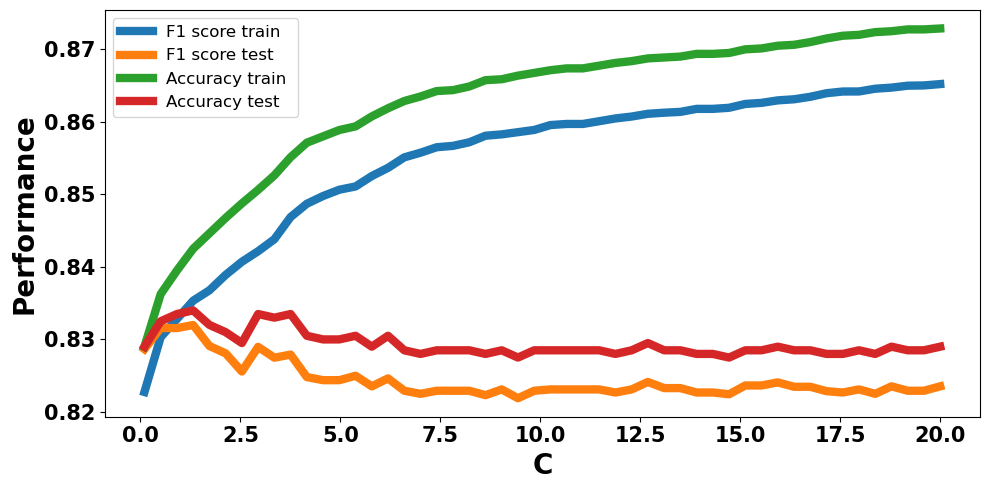

In [11]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=SVC( C=params, random_state=3), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

#Calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 1.123224489795918}
0.8425
0.834


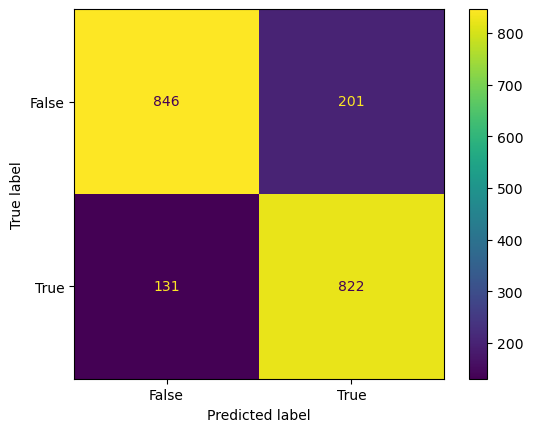

In [13]:
clf = SVC( C=gs.best_params_['C'], random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

## Partie III - Regression logistique

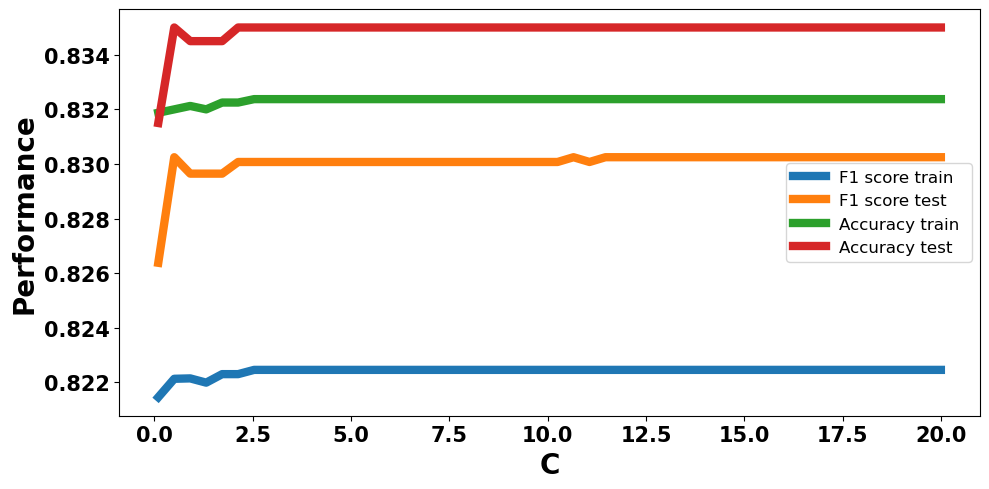

In [14]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

                        
C_range = np.linspace(0.1, 20, 50)

for param in C_range:
    clf = LogisticRegression(C=param,random_state=3, penalty="l1",solver='liblinear' )
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

#TOUJOURS GRAPH UN PEU BIZARRE -> PQ PERFORMANCE MEILLEURE SUR TEST QUE SUR TRAIN???
# Pas de diminution de la performance quand regularisation diminue?

In [15]:
# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
# ATTENTION -> gain de selection des paramètres via cross validation est marginal par rapport à la selection des bonnes variables 
# On utilise GridSearch ici parce qu'on veut combiner plusieurs paramètres

#  By default, scikit-learn's GridSearchCV does not select the most parsimonious model (fewer features)
# when multiple models have equal scores. GridSearchCV uses the mean cross-validated score to select
# the best model based on the specified scoring metric.
# If there are multiple models with the same highest mean score, GridSearchCV selects
# the one with the smallest value of the parameters.

# If we want to select the most parsimonious model among those with equal scores,
# you may need to implement a custom scoring function

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

                       params  mean_test_score  std_test_score
0                {'C': 0.001}         0.537125        0.000306
1   {'C': 0.1030204081632653}         0.830125        0.010143
2   {'C': 0.2050408163265306}         0.830375        0.009950
3   {'C': 0.3070612244897959}         0.830750        0.009112
4   {'C': 0.4090816326530612}         0.831375        0.008991
5   {'C': 0.5111020408163265}         0.831750        0.008646
6   {'C': 0.6131224489795918}         0.832250        0.008906
7   {'C': 0.7151428571428571}         0.832500        0.008979
8   {'C': 0.8171632653061224}         0.832500        0.008979
9   {'C': 0.9191836734693877}         0.832875        0.008773
10  {'C': 1.0212040816326529}         0.833000        0.008825
11   {'C': 1.123224489795918}         0.833000        0.008825
12  {'C': 1.2252448979591835}         0.832750        0.008584
13  {'C': 1.3272653061224489}         0.832500        0.008588
14   {'C': 1.429285714285714}         0.832375        0

In [16]:
# On refait meme process en jouant en + sur le critère de penalty et le tol
# tol = tolerance for stopping criteria. It defines the stopping criterion for the solver to converge to a solution.

params= { 'C':np.linspace(0.001, 5, 50),'tol': [0.01, 0.1, 1, 10] }


gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 1.123224489795918, 'tol': 0.01}
0.8325
0.8345


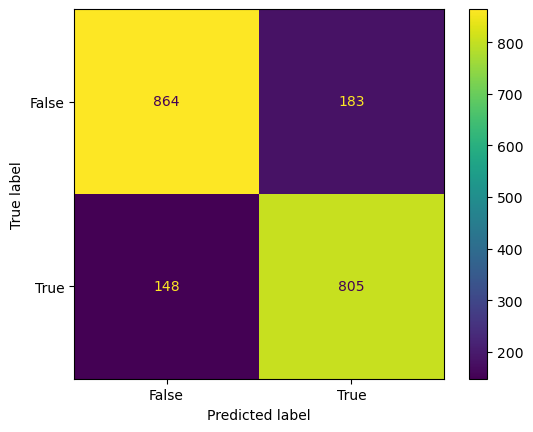

In [17]:
clf = LogisticRegression( tol=gs.best_params_['tol'], C=gs.best_params_['C'], random_state=3,
                         penalty ="l1", solver='liblinear')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [18]:
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)
#All variables are kept 

Number of variables considered: 37


## Partie IV : Selections de variables

In [19]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

# X transform contient un nombre réduit de caractéristiques basé sur la sélection
# des caractéristiques par régression Lasso
sfm.fit(X,y)
X_transform = sfm.transform(X)
print("Transformed data shape:", X_transform.shape)
print("Original data shape:", X.shape)

Transformed data shape: (10000, 10)
Original data shape: (10000, 37)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }



gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

#Perd un peu en performance avec 10 variables max

{'C': 0.42914285714285716, 'tol': 0.01}
0.824625
0.823


Number of variables considered: 10
[[ 1.12543323  0.96461019 -2.53147161  1.12675825  1.11899368 -0.7697726
   0.75506102  0.35639353 -1.2005218  -0.16829013]]


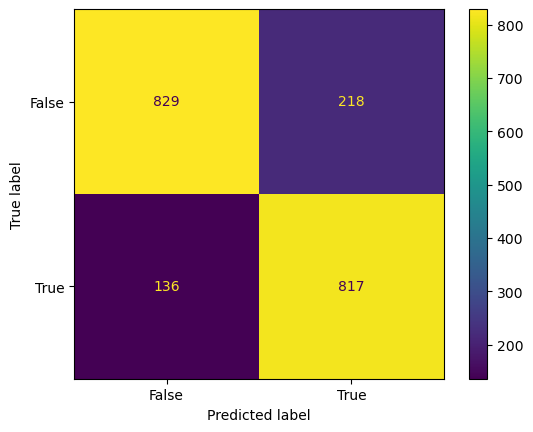

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

In [22]:
#Identify the indices of the variables used for prediction in X_transform
variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]

X_transform_useful_variables = X_transform[:,variables_indices]

# X_transform n'a pas les meme indices pour les colonnes que X ou EEC_2019 -> Je verifie quelle colonne a les meme 
# valeurs
for j in range(X_transform_useful_variables.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_useful_variables[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column  is equal to the {column_name} column in EEC_2019_subsample")

The 1 column  is equal to the AGE3_30 column in EEC_2019_subsample
The 2 column  is equal to the AGE5_50 column in EEC_2019_subsample
The 3 column  is equal to the AGE5_60 column in EEC_2019_subsample
The 4 column  is equal to the DIP11_10.0 column in EEC_2019_subsample
The 5 column  is equal to the DIP11_11.0 column in EEC_2019_subsample
The 6 column  is equal to the DIP11_60.0 column in EEC_2019_subsample
The 7 column  is equal to the TYPMEN7_1 column in EEC_2019_subsample
The 8 column  is equal to the TYPMEN7_6 column in EEC_2019_subsample
The 9 column  is equal to the COUPLE column in EEC_2019_subsample
The 10 column  is equal to the ENFANT column in EEC_2019_subsample


In [23]:
# J'essaie de reconstruire la variable predite à partir des 3 variables et des coefs associés
linear_pred_3 = clf.intercept_ + np.dot(X_test_2[:, variables_indices], clf.coef_[:, variables_indices].T) 
y_pred_3 = 1 / (1 + np.exp(-linear_pred_3))
threshold = 0.5  
y_pred_3_binary = (y_pred_3 > threshold).astype(bool).ravel()

comparison = np.equal(y_pred_2, y_pred_3_binary)
equal_predictions = np.sum(comparison)
percentage_equal = (equal_predictions / len(y_pred_2)) * 100 
print("% same predictor",percentage_equal)

% same predictor 100.0


## Partie V : Compréhension du problème de prédiction

Je pense que les problèmes de prédiction proviennent des chômeurs de courte durée qui ont donc des caractéristiques très similaires aux actifs de ma base, et sont donc prédits comme tels. Pour vérifier cela, je vais maintenant étudier la prédiction du fait d'être actif pour voir si nous parvenons à construire un meilleur prédicteur.





In [24]:
# Array contentant la variable expliquée
y_bis = np.array(EEC_2019_subsample["ACTIF"])
print(y_bis.shape)

print(y_bis[:10])

(10000,)
[ True False False  True False  True  True  True  True False]


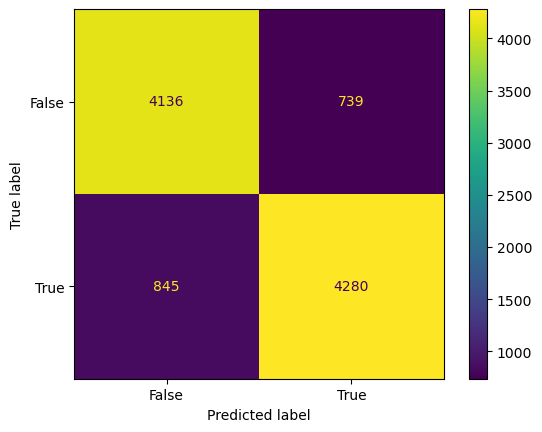

In [25]:
y_pred = clf.predict(X_transform)

cm= confusion_matrix(y_bis,y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

# Prédicteur de l'emploi déjà très bon pour prédire actif/pas actif => logique

(10000, 10)
[[ 1.40682921  1.06360717 -2.48776968  0.91459614 -0.80676333  0.4067382
   0.          0.         -0.7459575  -0.06873239]]
Number of variables considered: 8


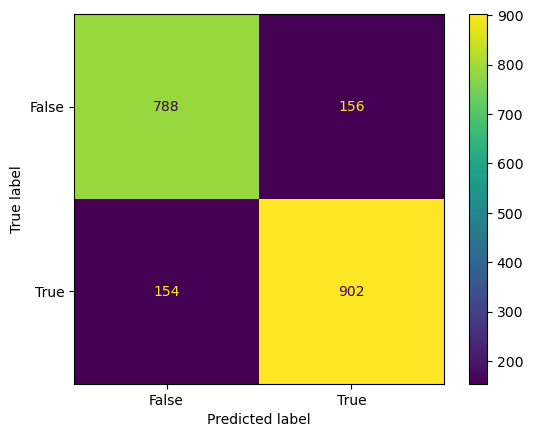

In [27]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y_bis)

# Je m'impose un maximum de 3 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

sfm.fit(X,y_bis)

X_transform_bis = sfm.transform(X)
print(X_transform_bis.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform_bis, 
                                                    y_bis, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }

gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

print(clf.coef_)
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

In [28]:

#=> ON dirait que les indices des colonnes change lorsqu'on passe de X à X_transform
# => ['AGE3_15' 'AGE3_30' 'AGE3_50'] ne sont pas les "bonnes" variables
# Iterate over a range of columns in X_transform_bis
for j in range(X_transform_bis.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_bis[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column in X_transform_bis is equal to the {column_name} column in EEC_2019_subsample")

The 1 column in X_transform_bis is equal to the AGE3_30 column in EEC_2019_subsample
The 2 column in X_transform_bis is equal to the AGE5_50 column in EEC_2019_subsample
The 3 column in X_transform_bis is equal to the AGE5_60 column in EEC_2019_subsample
The 4 column in X_transform_bis is equal to the DIP11_10.0 column in EEC_2019_subsample
The 5 column in X_transform_bis is equal to the DIP11_60.0 column in EEC_2019_subsample
The 6 column in X_transform_bis is equal to the TYPMEN7_1 column in EEC_2019_subsample
The 7 column in X_transform_bis is equal to the TYPMEN7_4 column in EEC_2019_subsample
The 8 column in X_transform_bis is equal to the TYPMEN7_6 column in EEC_2019_subsample
The 9 column in X_transform_bis is equal to the COUPLE column in EEC_2019_subsample
The 10 column in X_transform_bis is equal to the ENFANT column in EEC_2019_subsample


Il semblerait que le problème vienne effectivement de la distinction qui peut être parfois difficile à faire entre les chomeurs et les actifs occupés puisque les résultats s'améliorent grandement

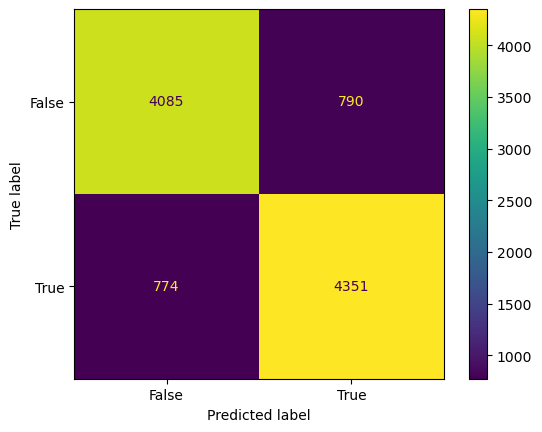

In [29]:
y_pred_4 = clf.predict(X_transform_bis)

cm= confusion_matrix(y_bis,y_pred_4)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

(316019, 10)


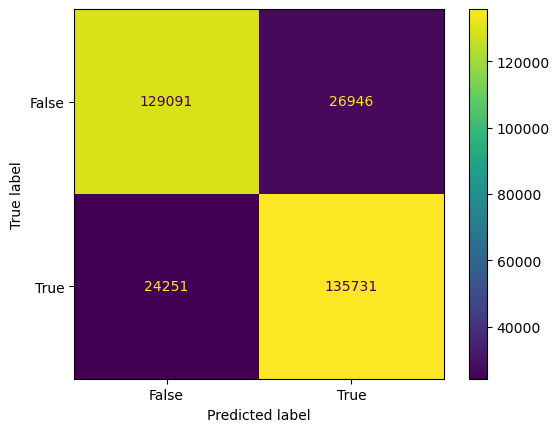

In [30]:
X_2020 = np.array(EEC_2020.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
y_2020 = np.array(EEC_2020["ACTIF"])

X_2020_transform = sfm.transform(X_2020)
print(X_2020_transform.shape)

y_pred_2020 = clf.predict(X_2020_transform)


cm= confusion_matrix(y_2020,y_pred_2020)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()